
# Classification with Credit Card Default (ISLR Default.csv)

This notebook reproduces the figures and calculations referenced in the lecture slides using the `Default.csv` data set.
All figures are saved under `figs/` with the specific filenames used by the slides.


In [2]:

# Setup
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IMPORTANT: per project rules, do NOT set custom matplotlib styles or colors.
# One chart per figure; no seaborn.

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Paths
DATA_PATH = "Default.csv"
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PATH)

# Normalize column names (strip & lower) and build a clean view
df.columns = [c.strip().lower() for c in df.columns]

# Expected columns in ISLR Default.csv: default, student, balance, income
# Coerce types and tidy
if "default" in df.columns:
    # Ensure string form is consistent
    df["default"] = df["default"].astype(str).str.strip().str.title()
    # Binary target: 1 if Yes else 0
    df["y"] = (df["default"] == "Yes").astype(int)
else:
    raise ValueError("Column 'default' not found. Expected in Default.csv.")

if "student" in df.columns:
    df["student"] = df["student"].astype(str).str.strip().str.title()
    df["student_yes"] = (df["student"] == "Yes").astype(int)
else:
    raise ValueError("Column 'student' not found. Expected in Default.csv.")

# Numeric predictors
for col in ["balance", "income"]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found. Expected in Default.csv.")
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop any rows with missing key fields
df = df.dropna(subset=["y", "balance", "income", "student_yes"]).copy()

# Quick sanity check
df.head(3)


,default,student,balance,income,y,student_yes
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0



## Example: Credit Card Default — Scatter & Boxplots

This section creates two figures referenced in the slides:

- `figs/4_1a-1.png`: Scatter of **income vs balance** with markers indicating default status.
- `figs/4_1b-1.png`: Boxplots comparing **balance** and **income** for default "Yes" vs "No".


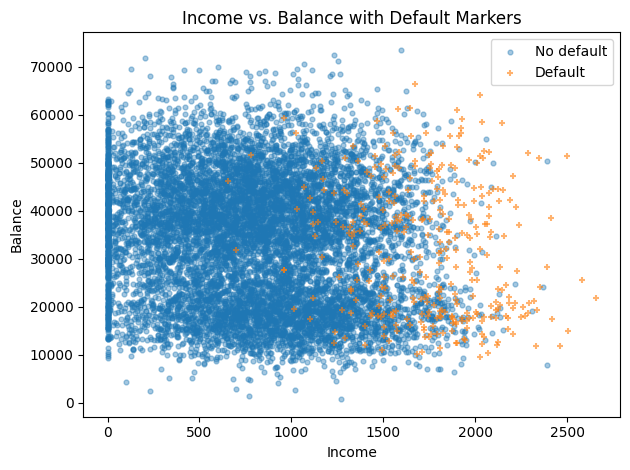

In [6]:

# Figure 4_1a-1: Scatter plot income vs balance by default
plt.figure()
mask_yes = df["y"] == 1
mask_no = df["y"] == 0

# Non-defaults
plt.scatter(df.loc[mask_no, "balance"], df.loc[mask_no, "income"],
            s=12, alpha=0.4, marker='o', label="No default")

# Defaults
plt.scatter(df.loc[mask_yes, "balance"], df.loc[mask_yes, "income"],
            s=18, alpha=0.6, marker='+', label="Default")

plt.xlabel("Income")
plt.ylabel("Balance")
plt.title("Income vs. Balance with Default Markers")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_1a-1.png"), dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipython-input-3934723416.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(groups, labels=["No", "Yes"], showmeans=True)
/tmp/ipython-input-3934723416.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(groups_inc, labels=["No", "Yes"], showmeans=True)


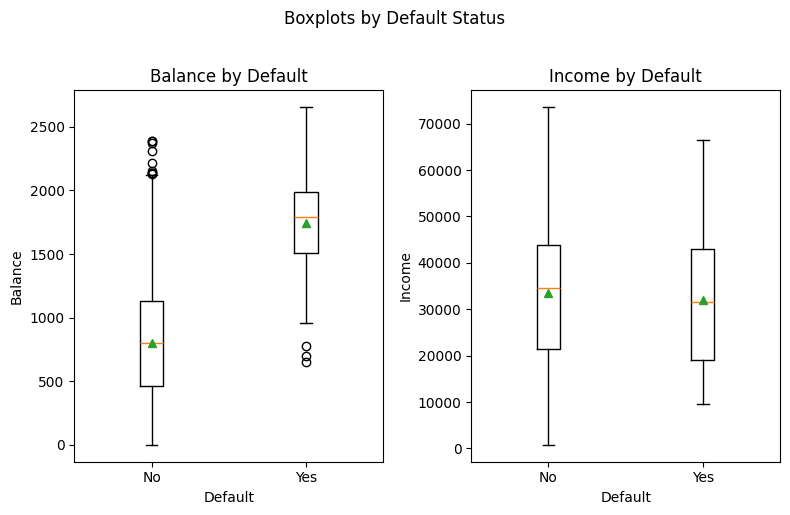

In [7]:

# Figure 4_1b-1: Boxplots of balance and income by default
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,5))
gs = GridSpec(1, 2, figure=fig)

# Balance boxplot
ax1 = fig.add_subplot(gs[0, 0])
groups = [df.loc[df["y"]==0, "balance"], df.loc[df["y"]==1, "balance"]]
ax1.boxplot(groups, labels=["No", "Yes"], showmeans=True)
ax1.set_title("Balance by Default")
ax1.set_xlabel("Default")
ax1.set_ylabel("Balance")

# Income boxplot
ax2 = fig.add_subplot(gs[0, 1])
groups_inc = [df.loc[df["y"]==0, "income"], df.loc[df["y"]==1, "income"]]
ax2.boxplot(groups_inc, labels=["No", "Yes"], showmeans=True)
ax2.set_title("Income by Default")
ax2.set_xlabel("Default")
ax2.set_ylabel("Income")

fig.suptitle("Boxplots by Default Status", y=1.02)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "4_1b-1.png"), dpi=300, bbox_inches="tight")
plt.show()



## Can we use Linear Regression? (Binary $Y$)

We fit a linear regression of the binary outcome on `balance` and evaluate predictions.


In [8]:

# Linear regression with binary Y ~ balance
X_lin = sm.add_constant(df["balance"])
lin_mod = sm.OLS(df["y"], X_lin).fit()

# Predictions across a grid
xgrid = np.linspace(df["balance"].min(), df["balance"].max(), 400)
Xg = sm.add_constant(pd.Series(xgrid, name="balance"))
lin_pred = lin_mod.predict(Xg)

lin_summary = {
    "coef": lin_mod.params.to_dict(),
    "min_pred": float(lin_pred.min()),
    "max_pred": float(lin_pred.max())
}

lin_summary


{'coef': {'const': -0.07519195884622265, 'balance': 0.00012987218159744949},
 'min_pred': -0.07519195884622265,
 'max_pred': 0.2695307047986468}


## Linear versus Logistic Regression: Probability of Default

Fit both linear (for illustration) and logistic regression models using `balance` only, and plot:
- Observed $Y\in\{0,1\}$ (jittered vertically)
- Linear regression fitted line
- Logistic regression fitted probability curve

Saved as `figs/4_2-1.png`.


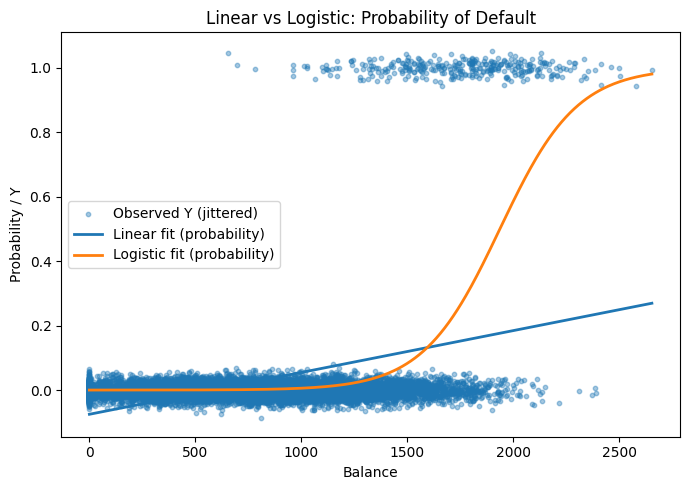

,Term,Coefficient,Std. Error,Z-statistic,P-value
0,Intercept,-10.6513,0.3612,-29.4913,< 0.0001
1,balance,0.0055,0.0002,24.9524,< 0.0001


In [9]:

# Logistic regression p(Y=1|balance)
logit_mod_bal = sm.Logit(df["y"], sm.add_constant(df[["balance"]])).fit(disp=False)

# Compute probability curve on grid
Xg2 = sm.add_constant(pd.DataFrame({"balance": xgrid}))
logit_pred = logit_mod_bal.predict(Xg2)

# Jitter observed Y to visualize 0/1 points
rng = np.random.default_rng(42)
y_jit = df["y"] + rng.normal(0, 0.02, size=len(df))

plt.figure(figsize=(7,5))
plt.scatter(df["balance"], y_jit, s=10, alpha=0.4, label="Observed Y (jittered)")
plt.plot(xgrid, lin_pred, linewidth=2, label="Linear fit (probability)")
plt.plot(xgrid, logit_pred, linewidth=2, label="Logistic fit (probability)")
plt.xlabel("Balance")
plt.ylabel("Probability / Y")
plt.title("Linear vs Logistic: Probability of Default")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_2-1.png"), dpi=300, bbox_inches="tight")
plt.show()

# Show coefficient table for logistic (balance only)
import pandas as pd
def coef_table(fit, names=None, dec=4):
    # Statsmodels Logit has params, bse, tvalues (z), pvalues
    params = fit.params
    bse = fit.bse
    z = fit.tvalues
    p = fit.pvalues
    out = pd.DataFrame({
        "Coefficient": params,
        "Std. Error": bse,
        "Z-statistic": z,
        "P-value": p
    })
    out.index.name = "Term"
    out = out.reset_index()
    if names:
        out["Term"] = out["Term"].replace(names)
    # Round
    for col in ["Coefficient", "Std. Error", "Z-statistic", "P-value"]:
        out[col] = out[col].astype(float)
    out["P-value"] = out["P-value"].apply(lambda v: "< 0.0001" if v < 1e-4 else f"{v:.4f}")
    for col in ["Coefficient", "Std. Error", "Z-statistic"]:
        out[col] = out[col].round(dec)
    return out

tab_bal = coef_table(logit_mod_bal, names={"const":"Intercept","balance":"balance"})
tab_bal



## Making Predictions (Balance-only Logistic)

Compute predicted probabilities for balances of 1000 and 2000 using the fitted logistic model.


In [10]:

b0, b1 = float(logit_mod_bal.params["const"]), float(logit_mod_bal.params["balance"])

def logit_p(x, b0, b1):
    return math.exp(b0 + b1*x) / (1.0 + math.exp(b0 + b1*x))

p_1000 = logit_p(1000, b0, b1)
p_2000 = logit_p(2000, b0, b1)

pd.DataFrame({
    "X (balance)":[1000, 2000],
    "Predicted p(default=1)": [p_1000, p_2000]
})


,X (balance),Predicted p(default=1)
0,1000,0.005752
1,2000,0.585769



## Logistic Regression with `student` Predictor


In [11]:

logit_mod_student = sm.Logit(df["y"], sm.add_constant(df[["student_yes"]])).fit(disp=False)
tab_student = coef_table(logit_mod_student,
                         names={"const":"Intercept","student_yes":"student Yes"})
tab_student


,Term,Coefficient,Std. Error,Z-statistic,P-value
0,Intercept,-3.5041,0.0707,-49.5541,< 0.0001
1,student Yes,0.4049,0.1150,3.5202,0.0004


In [12]:

# Predicted probabilities by student status
b0s, b1s = float(logit_mod_student.params["const"]), float(logit_mod_student.params["student_yes"])

p_stud_yes = math.exp(b0s + b1s*1) / (1.0 + math.exp(b0s + b1s*1))
p_stud_no  = math.exp(b0s + b1s*0) / (1.0 + math.exp(b0s + b1s*0))

pd.DataFrame({
    "student": ["Yes","No"],
    "Predicted p(default=1)":[p_stud_yes, p_stud_no]
})


,student,Predicted p(default=1)
0,Yes,0.043139
1,No,0.029195



## Logistic Regression with Several Variables

Model: `default ~ balance + income + student_yes`


In [13]:

X_full = sm.add_constant(df[["balance","income","student_yes"]])
logit_mod_full = sm.Logit(df["y"], X_full).fit(disp=False)

tab_full = coef_table(logit_mod_full,
                      names={"const":"Intercept","balance":"balance",
                             "income":"income","student_yes":"student Yes"})
tab_full


,Term,Coefficient,Std. Error,Z-statistic,P-value
0,Intercept,-10.8690,0.4923,-22.0793,< 0.0001
1,balance,0.0057,0.0002,24.7365,< 0.0001
2,income,0.0000,0.0000,0.3698,0.7115
3,student Yes,-0.6468,0.2363,-2.7376,0.0062



## Confounding Illustration

We show how controlling for `balance` changes the relationship between `student` and default.
Two curves: predicted probability vs. `balance` for `student = Yes` and `student = No` from the multivariable model (income fixed at its mean).


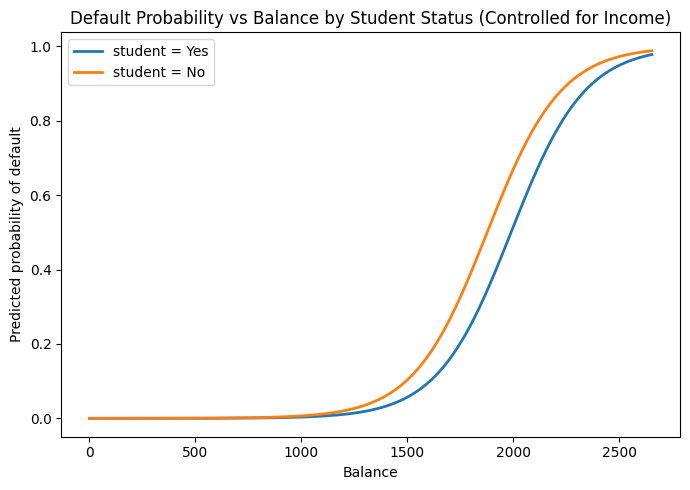

,student,Default rate
0,No,0.029195
1,Yes,0.043139


In [15]:

xg = np.linspace(df["balance"].min(), df["balance"].max(), 400)
income_mean = df["income"].mean()

def predict_full(balance, student_yes, income_val):
    X = pd.DataFrame({
        "const": 1.0,
        "balance": [balance],
        "income": [income_val],
        "student_yes": [student_yes]
    })
    pr = logit_mod_full.predict(X)[0]
    return pr

p_yes = [predict_full(x, 1, income_mean) for x in xg]
p_no  = [predict_full(x, 0, income_mean) for x in xg]

plt.figure(figsize=(7,5))
plt.plot(xg, p_yes, linewidth=2, label="student = Yes")
plt.plot(xg, p_no,  linewidth=2, label="student = No")
plt.xlabel("Balance")
plt.ylabel("Predicted probability of default")
plt.title("Default Probability vs Balance by Student Status (Controlled for Income)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_3-1.png"), dpi=300, bbox_inches="tight")
plt.show()

# Also show marginal default rate by student (no controls) for reference
marg = df.groupby("student")["y"].mean().rename("Default rate").reset_index()
marg



## Maximum Likelihood (MLE) — Coin Flipping Example

We consider 10 flips with 5 heads (1) and 5 tails (0). The likelihood is \(L(p) = p^5 (1-p)^5\). We maximize the log-likelihood to find \(\hat p\).


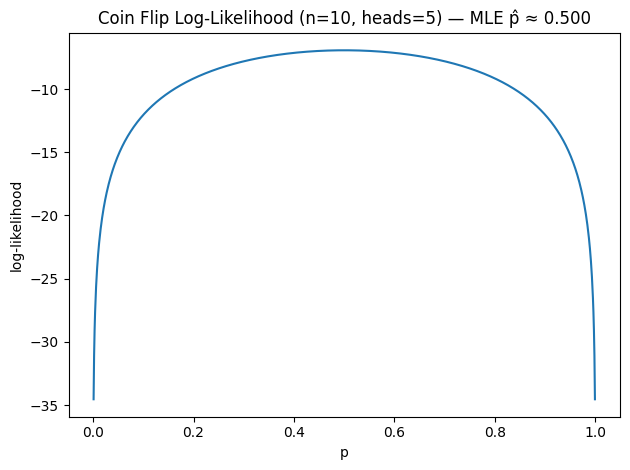

np.float64(0.5)

In [16]:

# Coin flipping MLE demo: 5 heads out of 10
n = 10
k = 5

p_grid = np.linspace(0.001, 0.999, 999)
loglik = k*np.log(p_grid) + (n-k)*np.log(1-p_grid)
p_hat = p_grid[np.argmax(loglik)]

plt.figure()
plt.plot(p_grid, loglik)
plt.xlabel("p")
plt.ylabel("log-likelihood")
plt.title(f"Coin Flip Log-Likelihood (n={n}, heads={k}) — MLE p̂ ≈ {p_hat:.3f}")
plt.tight_layout()
plt.show()

p_hat



## Maximum Likelihood — Mean of Normal ($\sigma=1$ known)

We verify numerically that the MLE for $\mu$ is the sample mean.


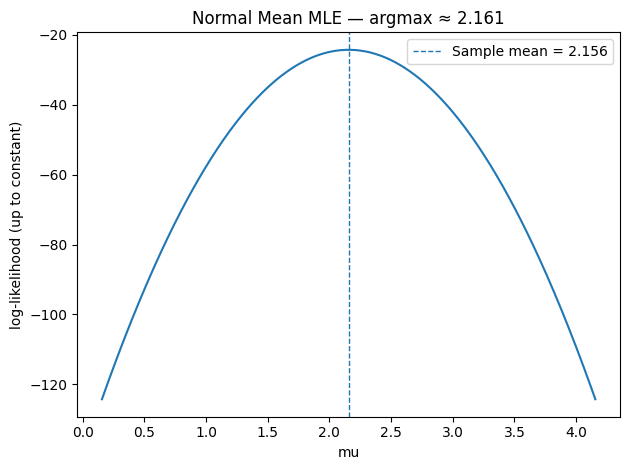

{'sample_mean': 2.1558327412124565, 'mle_mu_argmax': 2.160845272540777}

In [18]:

# Simulated sample for illustration (sigma=1)
rng = np.random.default_rng(123)
x = rng.normal(loc=2.0, scale=1.0, size=50)
xbar = x.mean()

mu_grid = np.linspace(xbar-2, xbar+2, 400)
loglik_mu = -0.5*np.sum((x.reshape(-1,1) - mu_grid.reshape(1,-1))**2, axis=0)  # up to a constant

mu_hat = mu_grid[np.argmax(loglik_mu)]

plt.figure()
plt.plot(mu_grid, loglik_mu)
plt.axvline(xbar, linestyle="--", linewidth=1, label=f"Sample mean = {xbar:.3f}")
plt.xlabel("mu")
plt.ylabel("log-likelihood (up to constant)")
plt.title(f"Normal Mean MLE — argmax ≈ {mu_hat:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

{"sample_mean": float(xbar), "mle_mu_argmax": float(mu_hat)}
